# Cross-Asset Volatility Forecasting: Multi-Horizon Analysis with Trading Strategies

This notebook extends the volatility forecasting framework to:
- **30 stocks** across market caps and sectors (SPY, QQQ + 28 others)
- **Multiple forecast horizons**: 1d, 5d, 20d
- **GARCH/EGARCH baselines**: Additional econometric benchmarks
- **Trading strategies**: Vol-scaled strategies with transaction costs
- **Performance metrics**: Sharpe ratios, drawdowns, robustness across periods
- **Honest analysis**: What works and what doesn't

Uses the same feature engineering, models, and evaluation framework as `main.ipynb`.

## Debug Mode

Set `DEBUG_MODE = True` in Cell 1 to run a quick test with:
- **1 stock** (SPY)
- **2 horizons** (1d, 5d)

This allows you to verify that all models (GARCH, EGARCH, etc.) and visualizations work correctly before running the full analysis.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy import fft, signal
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize_scalar
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ============================================================================
# CONFIGURATION
# ============================================================================

# DEBUG MODE: Set to True for quick testing (1 stock, 2 horizons)
DEBUG_MODE = True  # Set to False for full analysis

# Core parameters
ROLLING_WINDOW = 30
FORECAST_HORIZONS = [1, 5] if DEBUG_MODE else [1, 5, 20]  # Multiple horizons: 1d, 5d, 20d

# Feature toggles
ENABLE_SARIMA = True
ENABLE_FOURIER = True
SARIMA_REFIT_FREQ = 5

# Data quality filters
MIN_BARS_PER_DAY = 20
FILTER_WEEKENDS = True
FILTER_ZERO_RV = True

# Neural network parameters
NN_EPOCHS = 500
NN_PATIENCE = 50
NN_BATCH_SIZE = 64

# Technical indicator parameters
RSI_PERIOD = 14
AUTOCORR_LAGS = [1, 2, 3, 5, 10]

# Feature parameters
RV_RATIO_LOOKBACK_20D = 20
RV_RATIO_2D_14D = (2, 14)

# Time series parameters
FOURIER_WINDOW = 63
SARIMA_WINDOW = 252
SARIMA_ORDER = (1, 1, 1)
SARIMA_SEASONAL = (1, 1, 1, 5)

# Trading strategy parameters
TRANSACTION_COST_BPS = 5  # 5 basis points per trade
INITIAL_CAPITAL = 100000  # $100k initial capital

# Selected stocks (30 total: SPY, QQQ + 28 others across sectors)
SELECTED_STOCKS_FULL = [
    # ETFs
    'SPY', 'QQQ',
    # Tech
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META', 'AMD', 'INTC',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'C',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'LLY', 'ABBV',
    # Consumer
    'AMZN', 'HD', 'MCD', 'NKE', 'SBUX',
    # Energy
    'XOM', 'CVX', 'COP',
    # Industrial
    'BA', 'CAT', 'GE',
    # Other
    'TSLA', 'WMT', 'V'
]

# Use debug mode selection
SELECTED_STOCKS = ['SPY'] if DEBUG_MODE else SELECTED_STOCKS_FULL

print(f"Configuration:")
print(f"  DEBUG_MODE: {DEBUG_MODE}")
if DEBUG_MODE:
    print(f"  ⚠️  DEBUG MODE: Testing with 1 stock and 2 horizons")
print(f"  Rolling window: {ROLLING_WINDOW} days")
print(f"  Forecast horizons: {FORECAST_HORIZONS} days")
print(f"  Number of assets: {len(SELECTED_STOCKS)}")
print(f"  Transaction cost: {TRANSACTION_COST_BPS} bps")
print(f"  Feature toggles: SARIMA={ENABLE_SARIMA}, Fourier={ENABLE_FOURIER}")
print()


Configuration:
  DEBUG_MODE: True
  ⚠️  DEBUG MODE: Testing with 1 stock and 2 horizons
  Rolling window: 30 days
  Forecast horizons: [1, 5] days
  Number of assets: 1
  Transaction cost: 5 bps
  Feature toggles: SARIMA=True, Fourier=True



In [15]:
# ============================================================================
# HELPER FUNCTIONS (from main.ipynb)
# ============================================================================

def compute_rsi(series, period=14):
    """Compute Relative Strength Index (RSI) on a series."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_rolling_autocorr(series, window, lag):
    """Compute rolling autocorrelation at a specific lag."""
    result = pd.Series(index=series.index, dtype=float)
    for i in range(window + lag - 1, len(series)):
        window_data = series.iloc[i - window + 1:i + 1]
        if len(window_data) >= window:
            x = window_data.iloc[lag:].values
            y = window_data.iloc[:-lag].values
            if len(x) > 1 and np.std(x) > 0 and np.std(y) > 0:
                corr = np.corrcoef(x, y)[0, 1]
                result.iloc[i] = corr
            else:
                result.iloc[i] = np.nan
        else:
            result.iloc[i] = np.nan
    return result

def compute_metrics(y_true, y_pred, y_true_rv_diff=None, y_pred_rv_diff=None):
    """Compute comprehensive metrics for RV change forecasting."""
    metrics = {}
    metrics['rmse_logdiff'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae_logdiff'] = mean_absolute_error(y_true, y_pred)
    
    if y_true_rv_diff is not None and y_pred_rv_diff is not None:
        metrics['rmse_diff'] = np.sqrt(mean_squared_error(y_true_rv_diff, y_pred_rv_diff))
        metrics['mae_diff'] = mean_absolute_error(y_true_rv_diff, y_pred_rv_diff)
        
        # Directional accuracy
        mask = (y_true_rv_diff != 0) & (y_pred_rv_diff != 0)
        if mask.sum() > 0:
            true_sign = np.sign(y_true_rv_diff[mask])
            pred_sign = np.sign(y_pred_rv_diff[mask])
            metrics['directional_accuracy'] = np.mean(true_sign == pred_sign)
        else:
            metrics['directional_accuracy'] = np.nan
    
    if len(y_true) > 1:
        corr, pval = pearsonr(y_true, y_pred)
        metrics['correlation'] = corr
        metrics['correlation_pval'] = pval
    else:
        metrics['correlation'] = np.nan
        metrics['correlation_pval'] = np.nan
    
    return metrics

print("Helper functions loaded.")


Helper functions loaded.


In [16]:
# ============================================================================
# DATA LOADING AND PROCESSING
# ============================================================================

def load_and_process_stock(ticker, data_dir='10y data'):
    """Load and process a single stock's 15-min data into daily RV."""
    csv_path = Path(f'{data_dir}/{ticker}_15m_prices.csv')
    
    if not csv_path.exists():
        print(f"Warning: {csv_path} not found, skipping {ticker}")
        return None
    
    df = pd.read_csv(csv_path)
    
    # Find date column
    date_cols = [c for c in df.columns if c.lower() in ['date','datetime','timestamp']]
    if not date_cols:
        print(f"Warning: No date column found for {ticker}")
        return None
    
    # Parse datetime
    df.index = pd.to_datetime(df[date_cols[0]], utc=True, errors='coerce')
    df = df.drop(columns=[date_cols[0]]).sort_index()
    df.index = df.index.tz_convert('America/New_York')
    
    # Find close column
    close_col = None
    for col in df.columns:
        if 'close' in col.lower():
            close_col = col
            break
    
    if close_col is None:
        print(f"Warning: No close column found for {ticker}")
        return None
    
    df['close'] = df[close_col].astype(float)
    
    # Compute log returns
    ret_15m = np.log(df['close']).diff().dropna()
    
    # Count bars per day
    bars_per_day = ret_15m.groupby(pd.Grouper(freq='D')).count()
    
    # Daily realized variance and volatility
    daily_rv_squared = ret_15m.groupby(pd.Grouper(freq='D')).apply(lambda x: (x ** 2).sum())
    daily_rv = np.sqrt(daily_rv_squared) * np.sqrt(252)  # Annualized
    
    # Data quality filtering
    daily_rv = daily_rv.dropna()
    
    if MIN_BARS_PER_DAY > 0:
        valid_days = bars_per_day[bars_per_day >= MIN_BARS_PER_DAY].index
        daily_rv = daily_rv[daily_rv.index.isin(valid_days)]
    
    if FILTER_WEEKENDS:
        daily_rv = daily_rv[daily_rv.index.dayofweek < 5]
    
    if FILTER_ZERO_RV:
        daily_rv = daily_rv[daily_rv > 0]
    
    return daily_rv, ret_15m

# Load all stocks
print("Loading and processing stocks...")
stock_data = {}
ret_data = {}

for ticker in tqdm(SELECTED_STOCKS, desc="Loading stocks"):
    result = load_and_process_stock(ticker)
    if result is not None:
        daily_rv, ret_15m = result
        stock_data[ticker] = daily_rv
        ret_data[ticker] = ret_15m
        print(f"  {ticker}: {len(daily_rv)} days, range {daily_rv.index.min()} to {daily_rv.index.max()}")
    else:
        print(f"  {ticker}: FAILED to load")

print(f"\nSuccessfully loaded {len(stock_data)} stocks")


Loading and processing stocks...


Loading stocks: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

  SPY: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00

Successfully loaded 1 stocks


In [17]:
# ============================================================================
# FEATURE ENGINEERING (from main.ipynb framework)
# ============================================================================

def create_features(daily_rv, forecast_target):
    """Create all features for a given stock and forecast horizon."""
    # Target: subsequent forecast_target-day rolling window mean vol
    rv_fwd_values = []
    rv_fwd_index = []
    
    for i in range(len(daily_rv)):
        if i + forecast_target < len(daily_rv):
            future_mean = daily_rv.iloc[i+1:i+1+forecast_target].mean()
            rv_fwd_values.append(future_mean)
            rv_fwd_index.append(daily_rv.index[i])
    
    rv_fwd = pd.Series(rv_fwd_values, index=rv_fwd_index)
    
    # Compute RV change targets
    eps = 1e-12
    rv_diff = rv_fwd - daily_rv.loc[rv_fwd.index]
    rv_logdiff = np.log(rv_fwd + eps) - np.log(daily_rv.loc[rv_fwd.index] + eps)
    
    # Technical indicators
    rsi_vol = compute_rsi(daily_rv, period=RSI_PERIOD)
    
    # Autocorrelation features
    autocorr_features = {}
    for lag in AUTOCORR_LAGS:
        window_size = max(ROLLING_WINDOW, 2 * lag + 5)
        autocorr_features[f'autocorr_lag{lag}'] = compute_rolling_autocorr(daily_rv, window=window_size, lag=lag)
    
    # RV ratios
    rv_ratio_20d = daily_rv / daily_rv.shift(RV_RATIO_LOOKBACK_20D)
    rv_ratio_2d_14d = daily_rv.shift(RV_RATIO_2D_14D[0]) / daily_rv.shift(RV_RATIO_2D_14D[1])
    
    # Rolling correlation
    corr_window = max(ROLLING_WINDOW, 20)
    rv_ratio_2d_14d_series = daily_rv.shift(RV_RATIO_2D_14D[0]) / daily_rv.shift(RV_RATIO_2D_14D[1])
    rv_corr_ratio = pd.Series(index=daily_rv.index, dtype=float)
    for i in range(corr_window, len(daily_rv)):
        window_ratio = rv_ratio_2d_14d_series.iloc[i-corr_window+1:i+1]
        window_rv = daily_rv.iloc[i-corr_window+1:i+1]
        mask = ~(window_ratio.isna() | window_rv.isna())
        if mask.sum() > 5:
            corr_val = np.corrcoef(window_ratio[mask].values, window_rv[mask].values)[0, 1]
            rv_corr_ratio.iloc[i] = corr_val if not np.isnan(corr_val) else np.nan
    
    # Time features
    day_of_week = daily_rv.index.dayofweek
    week_of_month = (daily_rv.index.day - 1) // 7 + 1
    month_of_year = daily_rv.index.month
    
    # Additional correlations and ranks
    rv_vol_corr_ratio = pd.Series(index=daily_rv.index, dtype=float)
    for i in range(corr_window, len(daily_rv)):
        window_vol = daily_rv.iloc[i-corr_window+1:i+1]
        window_corr = rv_corr_ratio.iloc[i-corr_window+1:i+1]
        mask = ~(window_vol.isna() | window_corr.isna())
        if mask.sum() > 5:
            corr_val = np.corrcoef(window_vol[mask].values, window_corr[mask].values)[0, 1]
            rv_vol_corr_ratio.iloc[i] = corr_val if not np.isnan(corr_val) else np.nan
    
    rsi_vol_rank = rsi_vol.expanding(min_periods=50).rank(pct=True)
    rv_ratio_20d_rank = rv_ratio_20d.expanding(min_periods=50).rank(pct=True)
    
    rolling_rv_21d = daily_rv.rolling(window=21, min_periods=21).mean()
    is_rv_gt_21d_mean = (daily_rv > rolling_rv_21d).astype(int)
    rv_today_ratio_21d_mean = daily_rv / rolling_rv_21d
    rv_today_ratio_21d_mean_rank = rv_today_ratio_21d_mean.expanding(min_periods=50).rank(pct=True)
    
    # Lagged RV features
    rv_lag1 = daily_rv.shift(1)
    rv_lag2 = daily_rv.shift(2)
    rv_lag5 = daily_rv.shift(5)
    rv_lag10 = daily_rv.shift(10)
    rv_change_1 = daily_rv - daily_rv.shift(1)
    rv_change_5 = daily_rv - daily_rv.shift(5)
    past_mean_7 = daily_rv.shift(1).rolling(window=7, min_periods=1).mean()
    past_mean_diff_7 = past_mean_7 - daily_rv
    
    # Fourier features (simplified - can be slow)
    fourier_dominant_freq = pd.Series(index=daily_rv.index, dtype=float)
    fourier_dominant_amp = pd.Series(index=daily_rv.index, dtype=float)
    fourier_total_energy = pd.Series(index=daily_rv.index, dtype=float)
    
    if ENABLE_FOURIER:
        for i in range(FOURIER_WINDOW - 1, len(daily_rv)):
            window_data = daily_rv.iloc[max(0, i - FOURIER_WINDOW + 1):i + 1].values
            if len(window_data) >= 20:
                try:
                    fft_vals = fft.fft(window_data)
                    freqs = fft.fftfreq(len(window_data))
                    power = np.abs(fft_vals)**2
                    power[0] = 0
                    dominant_idx = np.argmax(power[1:len(power)//2]) + 1
                    fourier_dominant_freq.iloc[i] = abs(freqs[dominant_idx])
                    fourier_dominant_amp.iloc[i] = power[dominant_idx]
                    fourier_total_energy.iloc[i] = np.sum(power)
                except:
                    pass
    
    # SARIMA features (simplified)
    sarima_forecast = pd.Series(index=daily_rv.index, dtype=float)
    sarima_residual_std = pd.Series(index=daily_rv.index, dtype=float)
    
    if ENABLE_SARIMA:
        last_fitted_model = None
        last_fitted_idx = -1
        for i in range(SARIMA_WINDOW - 1, len(daily_rv)):
            window_data = daily_rv.iloc[max(0, i - SARIMA_WINDOW + 1):i + 1].values
            if len(window_data) >= SARIMA_WINDOW // 2:
                if (i - last_fitted_idx) >= SARIMA_REFIT_FREQ or last_fitted_model is None:
                    try:
                        model = SARIMAX(window_data, order=SARIMA_ORDER, seasonal_order=SARIMA_SEASONAL,
                                       enforce_stationarity=False, enforce_invertibility=False)
                        fitted_model = model.fit(disp=False, maxiter=50)
                        last_fitted_model = fitted_model
                        last_fitted_idx = i
                    except:
                        pass
            
            if last_fitted_model is not None:
                try:
                    forecast = last_fitted_model.forecast(steps=1)
                    sarima_forecast.iloc[i] = forecast[0] if len(forecast) > 0 else np.nan
                    residuals = last_fitted_model.resid
                    sarima_residual_std.iloc[i] = np.std(residuals) if len(residuals) > 0 else np.nan
                except:
                    pass
    
    # Create feature dataframe
    df_features = pd.DataFrame({
        'rv_today': daily_rv,
        f'rv_fwd_{forecast_target}d': rv_fwd,
        f'rv_diff_{forecast_target}d': rv_diff,
        f'rv_logdiff_{forecast_target}d': rv_logdiff,
        'rsi_vol': rsi_vol,
        'rv_ratio_20d': rv_ratio_20d,
        'rv_ratio_2d_14d': rv_ratio_2d_14d,
        'rv_corr_ratio': rv_corr_ratio,
        'day_of_week': day_of_week,
        'week_of_month': week_of_month,
        'month_of_year': month_of_year,
        'rv_vol_corr_ratio': rv_vol_corr_ratio,
        'rsi_vol_rank': rsi_vol_rank,
        'rv_ratio_20d_rank': rv_ratio_20d_rank,
        'is_rv_gt_21d_mean': is_rv_gt_21d_mean,
        'rv_today_ratio_21d_mean': rv_today_ratio_21d_mean,
        'rv_today_ratio_21d_mean_rank': rv_today_ratio_21d_mean_rank,
        'rv_lag1': rv_lag1,
        'rv_lag2': rv_lag2,
        'rv_lag5': rv_lag5,
        'rv_lag10': rv_lag10,
        'rv_change_1': rv_change_1,
        'rv_change_5': rv_change_5,
        'past_mean_7': past_mean_7,
        'past_mean_diff_7': past_mean_diff_7,
        'fourier_dominant_freq': fourier_dominant_freq,
        'fourier_dominant_amp': fourier_dominant_amp,
        'fourier_total_energy': fourier_total_energy,
        'sarima_forecast': sarima_forecast,
        'sarima_residual_std': sarima_residual_std,
    })
    
    # Add autocorrelation features
    for feat_name, feat_series in autocorr_features.items():
        df_features[feat_name] = feat_series
    
    # Drop NaNs and zero RV
    df_features = df_features.dropna()
    df_features = df_features[df_features['rv_today'] > 0]
    
    return df_features

print("Feature engineering function created.")


Feature engineering function created.


In [18]:
# ============================================================================
# HAR-RV AND HAR-X FEATURE CREATION
# ============================================================================

def create_har_features(df_features, target_col):
    """Create HAR-RV features: daily, weekly (5-day), monthly (22-day) RV lags"""
    har_features = pd.DataFrame(index=df_features.index)
    har_features['rv_daily'] = df_features['rv_today'].shift(1)
    har_features['rv_weekly'] = df_features['rv_today'].shift(1).rolling(window=5, min_periods=5).mean()
    har_features['rv_monthly'] = df_features['rv_today'].shift(1).rolling(window=22, min_periods=22).mean()
    
    target = df_features[target_col]
    common_idx = har_features.index.intersection(target.index)
    har_features = har_features.loc[common_idx]
    target = target.loc[common_idx]
    
    mask = ~(har_features.isna().any(axis=1) | target.isna())
    har_features = har_features[mask]
    target = target[mask]
    
    return har_features, target

def create_harx_features(df_features, target_col, ret_15m_series):
    """Create HAR-X features: HAR-RV + lagged returns"""
    harx_features, target = create_har_features(df_features, target_col)
    
    # Compute daily returns from 15-min data
    daily_returns = ret_15m_series.groupby(pd.Grouper(freq='D')).sum()
    daily_returns.index = daily_returns.index.tz_localize(None).normalize()
    
    common_idx = harx_features.index.intersection(daily_returns.index)
    harx_features = harx_features.loc[common_idx]
    target = target.loc[common_idx]
    
    harx_features['ret_lag1'] = daily_returns.shift(1).loc[harx_features.index]
    harx_features['ret_lag2'] = daily_returns.shift(2).loc[harx_features.index]
    harx_features['ret_lag3'] = daily_returns.shift(3).loc[harx_features.index]
    
    mask = ~(harx_features.isna().any(axis=1) | target.isna())
    harx_features = harx_features[mask]
    target = target[mask]
    
    return harx_features, target

# ============================================================================
# GARCH/EGARCH MODELS (CORRECTED)
# ============================================================================

def fit_garch_forecast_correct(returns, forecast_steps=1):
    """
    Fit GARCH(1,1) and return AVERAGE forecasted volatility over next h steps.
    
    Args:
        returns: Daily returns series (NOT percentage, just decimal returns)
        forecast_steps: Number of steps ahead to forecast (h)
    
    Returns:
        Average annualized volatility forecast over next h days
    """
    try:
        # Use last 252 days for fitting (or all if less available)
        ret_window = returns.iloc[-252:] if len(returns) > 252 else returns
        
        # Remove any NaNs
        ret_window = ret_window.dropna()
        
        if len(ret_window) < 50:  # Need minimum data
            return np.nan
        
        # Multiply by 100 to convert to percentage (arch convention)
        ret_pct = ret_window * 100
        
        # Fit GARCH(1,1)
        model = arch_model(ret_pct, vol='Garch', p=1, q=1, dist='normal')
        fitted = model.fit(disp='off', show_warning=False)
        
        # Forecast variance for next h steps
        forecast = fitted.forecast(horizon=forecast_steps, reindex=False)
        
        # forecast.variance is a DataFrame with shape (1, forecast_steps)
        # Each column is the variance forecast for that step ahead
        variance_forecasts = forecast.variance.values[0, :]  # Shape: (forecast_steps,)
        
        # Convert variance forecasts from percentage^2 to decimal^2
        variance_forecasts_decimal = variance_forecasts / (100**2)
        
        # Average variance over the forecast horizon
        avg_variance = np.mean(variance_forecasts_decimal)
        
        # Convert to volatility
        avg_vol = np.sqrt(avg_variance)
        
        # Annualize
        avg_vol_annual = avg_vol * np.sqrt(252)
        
        return avg_vol_annual
        
    except Exception as e:
        return np.nan


def fit_egarch_forecast_correct(returns, forecast_steps=1):
    """
    Fit EGARCH(1,1) and return AVERAGE forecasted volatility over next h steps.
    
    Args:
        returns: Daily returns series (NOT percentage, just decimal returns)
        forecast_steps: Number of steps ahead to forecast (h)
    
    Returns:
        Average annualized volatility forecast over next h days
    """
    try:
        ret_window = returns.iloc[-252:] if len(returns) > 252 else returns
        ret_window = ret_window.dropna()
        
        if len(ret_window) < 50:
            return np.nan
        
        ret_pct = ret_window * 100
        
        # Fit EGARCH(1,1)
        model = arch_model(ret_pct, vol='EGARCH', p=1, q=1, dist='normal')
        fitted = model.fit(disp='off', show_warning=False)
        
        forecast = fitted.forecast(horizon=forecast_steps, reindex=False)
        variance_forecasts = forecast.variance.values[0, :]
        variance_forecasts_decimal = variance_forecasts / (100**2)
        avg_variance = np.mean(variance_forecasts_decimal)
        avg_vol = np.sqrt(avg_variance)
        avg_vol_annual = avg_vol * np.sqrt(252)
        
        return avg_vol_annual
        
    except Exception as e:
        return np.nan

print("HAR and GARCH functions created.")


HAR and GARCH functions created.


In [19]:
# ============================================================================
# TRADING STRATEGY FUNCTIONS
# ============================================================================

def compute_strategy_returns(predictions, actual_rv, current_rv, forecast_horizon, 
                             transaction_cost_bps=5, initial_capital=100000):
    """
    Simple vol-scaled trading strategy:
    - If predicted RV increase > threshold: go short volatility (negative position)
    - If predicted RV decrease > threshold: go long volatility (positive position)
    - Position size scaled by predicted magnitude
    - Transaction costs applied on position changes
    """
    # Convert log-diff predictions to RV change predictions
    eps = 1e-12
    pred_rv_fwd = np.exp(predictions + np.log(current_rv + eps)) - eps
    pred_rv_diff = pred_rv_fwd - current_rv
    
    # Actual future RV (for computing returns)
    actual_rv_fwd = actual_rv
    
    # Strategy: position = -sign(pred_rv_diff) * min(abs(pred_rv_diff) / current_rv, 1.0)
    # Negative position when RV predicted to increase (volatility goes up, we lose)
    # Positive position when RV predicted to decrease (volatility goes down, we win)
    positions = -np.sign(pred_rv_diff) * np.minimum(np.abs(pred_rv_diff) / (current_rv + eps), 1.0)
    
    # Compute strategy returns: -position * (actual_rv_fwd - current_rv) / current_rv
    # This approximates a volatility trading P&L
    strategy_returns = -positions * (actual_rv_fwd - current_rv) / (current_rv + eps)
    
    # Apply transaction costs on position changes
    position_changes = np.abs(np.diff(np.concatenate([[0], positions])))
    transaction_costs = position_changes * (transaction_cost_bps / 10000)
    strategy_returns_net = strategy_returns - transaction_costs
    
    # Compute cumulative equity curve
    equity = initial_capital * np.cumprod(1 + strategy_returns_net)
    
    return strategy_returns_net, equity, positions

# ============================================================================
# PERFORMANCE METRICS
# ============================================================================

def compute_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    """Compute annualized Sharpe ratio."""
    if len(returns) == 0 or np.std(returns) == 0:
        return np.nan
    excess_returns = returns - risk_free_rate / periods_per_year
    sharpe = np.sqrt(periods_per_year) * np.mean(excess_returns) / np.std(returns)
    return sharpe

def compute_max_drawdown(equity_curve):
    """Compute maximum drawdown."""
    if len(equity_curve) == 0:
        return np.nan
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max
    return np.min(drawdown)

def compute_calmar_ratio(returns, equity_curve, periods_per_year=252):
    """Compute Calmar ratio (annualized return / max drawdown)."""
    if len(returns) == 0:
        return np.nan
    annual_return = np.mean(returns) * periods_per_year
    max_dd = compute_max_drawdown(equity_curve)
    if max_dd == 0 or np.isnan(max_dd):
        return np.nan
    return annual_return / abs(max_dd)

print("Trading strategy and performance metrics functions created.")


Trading strategy and performance metrics functions created.


In [ ]:
# ============================================================================
# MAIN EXECUTION: Process all stocks, horizons, and models
# ============================================================================

# Define feature columns (same as main.ipynb)
feature_cols = [
    'rsi_vol', 'rv_ratio_20d', 'rv_ratio_2d_14d', 'rv_corr_ratio',
    'day_of_week', 'week_of_month', 'month_of_year', 'rv_vol_corr_ratio',
    'rsi_vol_rank', 'rv_ratio_20d_rank', 'is_rv_gt_21d_mean',
    'rv_today_ratio_21d_mean', 'rv_today_ratio_21d_mean_rank',
    'rv_lag1', 'rv_lag2', 'rv_lag5', 'rv_lag10',
    'rv_change_1', 'rv_change_5', 'past_mean_7', 'past_mean_diff_7',
    'fourier_dominant_freq', 'fourier_dominant_amp', 'fourier_total_energy',
    'sarima_forecast', 'sarima_residual_std',
] + [f'autocorr_lag{lag}' for lag in AUTOCORR_LAGS]

# Storage for all results
all_results = []

print("=" * 70)
if DEBUG_MODE:
    print("⚠️  DEBUG MODE: PROCESSING 1 STOCK, 2 HORIZONS")
    print("=" * 70)
else:
    print("PROCESSING ALL STOCKS, HORIZONS, AND MODELS")
    print("=" * 70)
print(f"Stocks: {len(stock_data)}")
print(f"Horizons: {FORECAST_HORIZONS}")
print(f"Models: Linear, RandomForest, HAR-RV, HAR-X, Neural Network, GARCH, EGARCH")
if DEBUG_MODE:
    print(f"\n⚠️  DEBUG MODE: This is a quick test run. Set DEBUG_MODE=False for full analysis.")
print()

# Process each stock
for ticker in tqdm(list(stock_data.keys()), desc="Processing stocks"):
    daily_rv = stock_data[ticker]
    ret_15m = ret_data[ticker]
    
    # Compute daily returns for GARCH models
    daily_returns = ret_15m.groupby(pd.Grouper(freq='D')).sum()
    
    # Process each forecast horizon
    for horizon in FORECAST_HORIZONS:
        print(f"\n{ticker} - {horizon}d horizon")
        
        try:
            # Create features
            df_features = create_features(daily_rv, horizon)
            
            if len(df_features) < 500:  # Need sufficient data
                print(f"  Insufficient data: {len(df_features)} samples")
                continue
            
            # Split data (60/20/20)
            n_total = len(df_features)
            n_train = int(0.6 * n_total)
            n_val = int(0.2 * n_total)
            n_test = n_total - n_train - n_val
            
            train_data = df_features.iloc[:n_train]
            val_data = df_features.iloc[n_train:n_train + n_val]
            test_data = df_features.iloc[n_train + n_val:]
            
            # Prepare features and targets
            X_train = train_data[feature_cols].values
            y_train = train_data[f'rv_logdiff_{horizon}d'].values
            y_train_rv_diff = train_data[f'rv_diff_{horizon}d'].values
            
            X_val = val_data[feature_cols].values
            y_val = val_data[f'rv_logdiff_{horizon}d'].values
            y_val_rv_diff = val_data[f'rv_diff_{horizon}d'].values
            
            X_test = test_data[feature_cols].values
            y_test = test_data[f'rv_logdiff_{horizon}d'].values
            y_test_rv_diff = test_data[f'rv_diff_{horizon}d'].values
            
            # Handle NaNs
            train_mask = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
            val_mask = ~(np.isnan(X_val).any(axis=1) | np.isnan(y_val))
            test_mask = ~(np.isnan(X_test).any(axis=1) | np.isnan(y_test))
            
            X_train = X_train[train_mask]
            y_train = y_train[train_mask]
            y_train_rv_diff = y_train_rv_diff[train_mask]
            
            X_val = X_val[val_mask]
            y_val = y_val[val_mask]
            y_val_rv_diff = y_val_rv_diff[val_mask]
            
            X_test = X_test[test_mask]
            y_test = y_test[test_mask]
            y_test_rv_diff = y_test_rv_diff[test_mask]
            
            if len(X_train) < 100 or len(X_test) < 50:
                print(f"  Insufficient clean data after filtering")
                continue
            
            # Store predictions for all models
            model_predictions = {}
            
            # 1. Linear Regression
            try:
                linear_model = LinearRegression()
                linear_model.fit(X_train, y_train)
                linear_pred_test = linear_model.predict(X_test)
                model_predictions['Linear'] = linear_pred_test
            except Exception as e:
                print(f"  Linear model failed: {e}")
                model_predictions['Linear'] = None
            
            # 2. Random Forest (simplified - no hyperparameter tuning for speed)
            try:
                rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, 
                                                random_state=42, n_jobs=-1)
                rf_model.fit(X_train, y_train)
                rf_pred_test = rf_model.predict(X_test)
                model_predictions['RandomForest'] = rf_pred_test
            except Exception as e:
                print(f"  RandomForest model failed: {e}")
                model_predictions['RandomForest'] = None
            
            # 3. HAR-RV
            try:
                har_X_train, har_y_train = create_har_features(train_data, f'rv_logdiff_{horizon}d')
                har_X_test, har_y_test = create_har_features(test_data, f'rv_logdiff_{horizon}d')
                if len(har_X_train) > 0 and len(har_X_test) > 0:
                    har_model = OLS(har_y_train, add_constant(har_X_train)).fit()
                    har_pred_test = har_model.predict(add_constant(har_X_test))
                    # Align with test data
                    har_pred_aligned = np.full(len(y_test), np.nan)
                    har_test_idx = har_y_test.index
                    test_idx = test_data.index[test_mask]
                    common_idx = test_idx.intersection(har_test_idx)
                    if len(common_idx) > 0:
                        har_pred_aligned[test_idx.isin(common_idx)] = har_pred_test.values
                    model_predictions['HAR-RV'] = har_pred_aligned
                else:
                    model_predictions['HAR-RV'] = None
            except Exception as e:
                print(f"  HAR-RV model failed: {e}")
                model_predictions['HAR-RV'] = None
            
            # 4. HAR-X
            try:
                harx_X_train, harx_y_train = create_harx_features(train_data, f'rv_logdiff_{horizon}d', ret_15m)
                harx_X_test, harx_y_test = create_harx_features(test_data, f'rv_logdiff_{horizon}d', ret_15m)
                if len(harx_X_train) > 0 and len(harx_X_test) > 0:
                    harx_model = OLS(harx_y_train, add_constant(harx_X_train)).fit()
                    harx_pred_test = harx_model.predict(add_constant(harx_X_test))
                    harx_pred_aligned = np.full(len(y_test), np.nan)
                    harx_test_idx = harx_y_test.index
                    test_idx = test_data.index[test_mask]
                    common_idx = test_idx.intersection(harx_test_idx)
                    if len(common_idx) > 0:
                        harx_pred_aligned[test_idx.isin(common_idx)] = harx_pred_test.values
                    model_predictions['HAR-X'] = harx_pred_aligned
                else:
                    model_predictions['HAR-X'] = None
            except Exception as e:
                print(f"  HAR-X model failed: {e}")
                model_predictions['HAR-X'] = None
            
            # 5. Neural Network (simplified)
            try:
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                scaler_X_nn = StandardScaler()
                scaler_y_nn = StandardScaler()
                
                X_train_scaled = scaler_X_nn.fit_transform(X_train)
                X_test_scaled = scaler_X_nn.transform(X_test)
                y_train_scaled = scaler_y_nn.fit_transform(y_train.reshape(-1, 1)).flatten()
                
                class SimpleNN(nn.Module):
                    def __init__(self, input_dim):
                        super().__init__()
                        self.net = nn.Sequential(
                            nn.Linear(input_dim, 64),
                            nn.ReLU(),
                            nn.Linear(64, 32),
                            nn.ReLU(),
                            nn.Linear(32, 1)
                        )
                    def forward(self, x):
                        return self.net(x).squeeze()
                
                nn_model = SimpleNN(X_train_scaled.shape[1]).to(device)
                optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()
                
                X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
                y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
                X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
                
                # Quick training (50 epochs)
                for epoch in range(50):
                    nn_model.train()
                    optimizer.zero_grad()
                    outputs = nn_model(X_train_tensor)
                    loss = criterion(outputs, y_train_tensor)
                    loss.backward()
                    optimizer.step()
                
                nn_model.eval()
                with torch.no_grad():
                    nn_pred_test_scaled = nn_model(X_test_tensor).cpu().numpy()
                nn_pred_test = scaler_y_nn.inverse_transform(nn_pred_test_scaled.reshape(-1, 1)).flatten()
                model_predictions['NeuralNetwork'] = nn_pred_test
            except Exception as e:
                print(f"  Neural Network model failed: {e}")
                model_predictions['NeuralNetwork'] = None
            
            # 6. GARCH and EGARCH (rolling forecasts on test set) - CORRECTED
            try:
                test_dates = test_data.index[test_mask]
                garch_preds = []
                egarch_preds = []
                
                # For each test point, use ONLY data BEFORE that point
                for i, test_date in enumerate(test_dates):
                    # CRITICAL: Get returns STRICTLY BEFORE test_date
                    # This prevents lookahead bias
                    returns_before_test = daily_returns[daily_returns.index < test_date]
                    
                    if len(returns_before_test) > 100:  # Need sufficient history
                        # Forecast average volatility over next h days
                        garch_pred = fit_garch_forecast_correct(returns_before_test, 
                                                                forecast_steps=horizon)
                        egarch_pred = fit_egarch_forecast_correct(returns_before_test, 
                                                                  forecast_steps=horizon)
                        
                        # Current RV at forecast origin
                        current_rv = test_data.loc[test_date, 'rv_today']
                        
                        # Convert to log-diff format (to match your target)
                        eps = 1e-12
                        if not np.isnan(garch_pred):
                            garch_logdiff = np.log(garch_pred + eps) - np.log(current_rv + eps)
                        else:
                            garch_logdiff = np.nan
                            
                        if not np.isnan(egarch_pred):
                            egarch_logdiff = np.log(egarch_pred + eps) - np.log(current_rv + eps)
                        else:
                            egarch_logdiff = np.nan
                        
                        garch_preds.append(garch_logdiff)
                        egarch_preds.append(egarch_logdiff)
                    else:
                        garch_preds.append(np.nan)
                        egarch_preds.append(np.nan)
                
                model_predictions['GARCH'] = np.array(garch_preds)
                model_predictions['EGARCH'] = np.array(egarch_preds)
            except Exception as e:
                print(f"  GARCH/EGARCH models failed: {e}")
                model_predictions['GARCH'] = None
                model_predictions['EGARCH'] = None
            
            # Evaluate all models and compute trading strategy performance
            test_rv_today = test_data.loc[test_data.index[test_mask], 'rv_today'].values
            test_rv_fwd = test_data.loc[test_data.index[test_mask], f'rv_fwd_{horizon}d'].values
            
            for model_name, pred_test in model_predictions.items():
                if pred_test is None or np.all(np.isnan(pred_test)):
                    continue
                
                # Align predictions (handle NaNs)
                valid_mask = ~np.isnan(pred_test)
                if valid_mask.sum() < 10:
                    continue
                
                y_test_valid = y_test[valid_mask]
                pred_test_valid = pred_test[valid_mask]
                test_rv_today_valid = test_rv_today[valid_mask]
                test_rv_fwd_valid = test_rv_fwd[valid_mask]
                y_test_rv_diff_valid = y_test_rv_diff[valid_mask]
                
                # Convert predictions to rv_diff
                eps = 1e-12
                pred_rv_fwd_valid = np.exp(pred_test_valid + np.log(test_rv_today_valid + eps)) - eps
                pred_rv_diff_valid = pred_rv_fwd_valid - test_rv_today_valid
                
                # Compute metrics
                metrics = compute_metrics(y_test_valid, pred_test_valid, 
                                         y_test_rv_diff_valid, pred_rv_diff_valid)
                r2 = r2_score(y_test_valid, pred_test_valid)
                metrics['r2'] = r2
                
                # Trading strategy performance
                try:
                    strategy_returns, equity, positions = compute_strategy_returns(
                        pred_test_valid, test_rv_fwd_valid, test_rv_today_valid, horizon,
                        TRANSACTION_COST_BPS, INITIAL_CAPITAL
                    )
                    
                    sharpe = compute_sharpe_ratio(strategy_returns)
                    max_dd = compute_max_drawdown(equity)
                    calmar = compute_calmar_ratio(strategy_returns, equity)
                    total_return = (equity[-1] / INITIAL_CAPITAL - 1) if len(equity) > 0 else np.nan
                    annual_return = np.mean(strategy_returns) * 252 if len(strategy_returns) > 0 else np.nan
                    volatility = np.std(strategy_returns) * np.sqrt(252) if len(strategy_returns) > 0 else np.nan
                except Exception as e:
                    sharpe = np.nan
                    max_dd = np.nan
                    calmar = np.nan
                    total_return = np.nan
                    annual_return = np.nan
                    volatility = np.nan
                
                # Store results
                result = {
                    'ticker': ticker,
                    'horizon': horizon,
                    'model': model_name,
                    'n_train': len(X_train),
                    'n_test': len(y_test_valid),
                    'r2': r2,
                    'rmse_logdiff': metrics.get('rmse_logdiff', np.nan),
                    'mae_logdiff': metrics.get('mae_logdiff', np.nan),
                    'correlation': metrics.get('correlation', np.nan),
                    'directional_accuracy': metrics.get('directional_accuracy', np.nan),
                    'sharpe_ratio': sharpe,
                    'max_drawdown': max_dd,
                    'calmar_ratio': calmar,
                    'total_return': total_return,
                    'annual_return': annual_return,
                    'volatility': volatility,
                }
                all_results.append(result)
                
        except Exception as e:
            print(f"  Error processing {ticker} {horizon}d: {e}")
            continue

print("\n" + "=" * 70)
print("PROCESSING COMPLETE")
print("=" * 70)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
print(f"\nTotal results: {len(results_df)}")
print(f"Stocks processed: {results_df['ticker'].nunique()}")
print(f"Horizons: {results_df['horizon'].unique()}")
print(f"Models: {results_df['model'].unique()}")


⚠️  DEBUG MODE: PROCESSING 1 STOCK, 2 HORIZONS
Stocks: 1
Horizons: [1, 5]
Models: Linear, RandomForest, HAR-RV, HAR-X, Neural Network, GARCH, EGARCH

⚠️  DEBUG MODE: This is a quick test run. Set DEBUG_MODE=False for full analysis.



Processing stocks:   0%|          | 0/1 [00:00<?, ?it/s]


SPY - 1d horizon


In [ ]:
# ============================================================================
# SUMMARY STATISTICS AND ANALYSIS
# ============================================================================

print("=" * 70)
print("SUMMARY STATISTICS BY MODEL AND HORIZON")
print("=" * 70)

if len(results_df) > 0:
    # Aggregate statistics
    summary = results_df.groupby(['model', 'horizon']).agg({
        'r2': ['mean', 'std', 'count'],
        'rmse_logdiff': ['mean', 'std'],
        'correlation': ['mean', 'std'],
        'directional_accuracy': ['mean', 'std'],
        'sharpe_ratio': ['mean', 'std'],
        'max_drawdown': ['mean', 'std'],
        'calmar_ratio': ['mean', 'std'],
        'total_return': ['mean', 'std'],
    }).round(4)
    
    print(summary)
    
    # Best performing models by metric
    print("\n" + "=" * 70)
    print("BEST PERFORMING MODELS (Average across all stocks)")
    print("=" * 70)
    
    for horizon in FORECAST_HORIZONS:
        print(f"\n{horizon}d Horizon:")
        horizon_df = results_df[results_df['horizon'] == horizon]
        
        if len(horizon_df) > 0:
            best_r2 = horizon_df.groupby('model')['r2'].mean().idxmax()
            best_sharpe = horizon_df.groupby('model')['sharpe_ratio'].mean().idxmax()
            best_calmar = horizon_df.groupby('model')['calmar_ratio'].mean().idxmax()
            
            print(f"  Best R²: {best_r2} ({horizon_df[horizon_df['model']==best_r2]['r2'].mean():.4f})")
            print(f"  Best Sharpe: {best_sharpe} ({horizon_df[horizon_df['model']==best_sharpe]['sharpe_ratio'].mean():.4f})")
            print(f"  Best Calmar: {best_calmar} ({horizon_df[horizon_df['model']==best_calmar]['calmar_ratio'].mean():.4f})")
else:
    print("No results to analyze yet. Run the main execution cell first.")


SUMMARY STATISTICS BY MODEL AND HORIZON
                             r2           rmse_logdiff     correlation      \
                           mean std count         mean std        mean std   
model         horizon                                                        
EGARCH        1       -103.0006 NaN     1       4.1036 NaN      0.1119 NaN   
GARCH         1         -0.1241 NaN     1       0.4266 NaN      0.4141 NaN   
              5          0.0700 NaN     1       0.3939 NaN      0.5392 NaN   
HAR-RV        1          0.0061 NaN     1       0.4016 NaN      0.0839 NaN   
              5          0.0372 NaN     1       0.4027 NaN      0.2102 NaN   
Linear        1          0.1516 NaN     1       0.3706 NaN      0.4019 NaN   
              5          0.2273 NaN     1       0.3591 NaN      0.5108 NaN   
NeuralNetwork 1          0.1656 NaN     1       0.3676 NaN      0.4128 NaN   
              5          0.3222 NaN     1       0.3363 NaN      0.5715 NaN   
RandomForest  1         

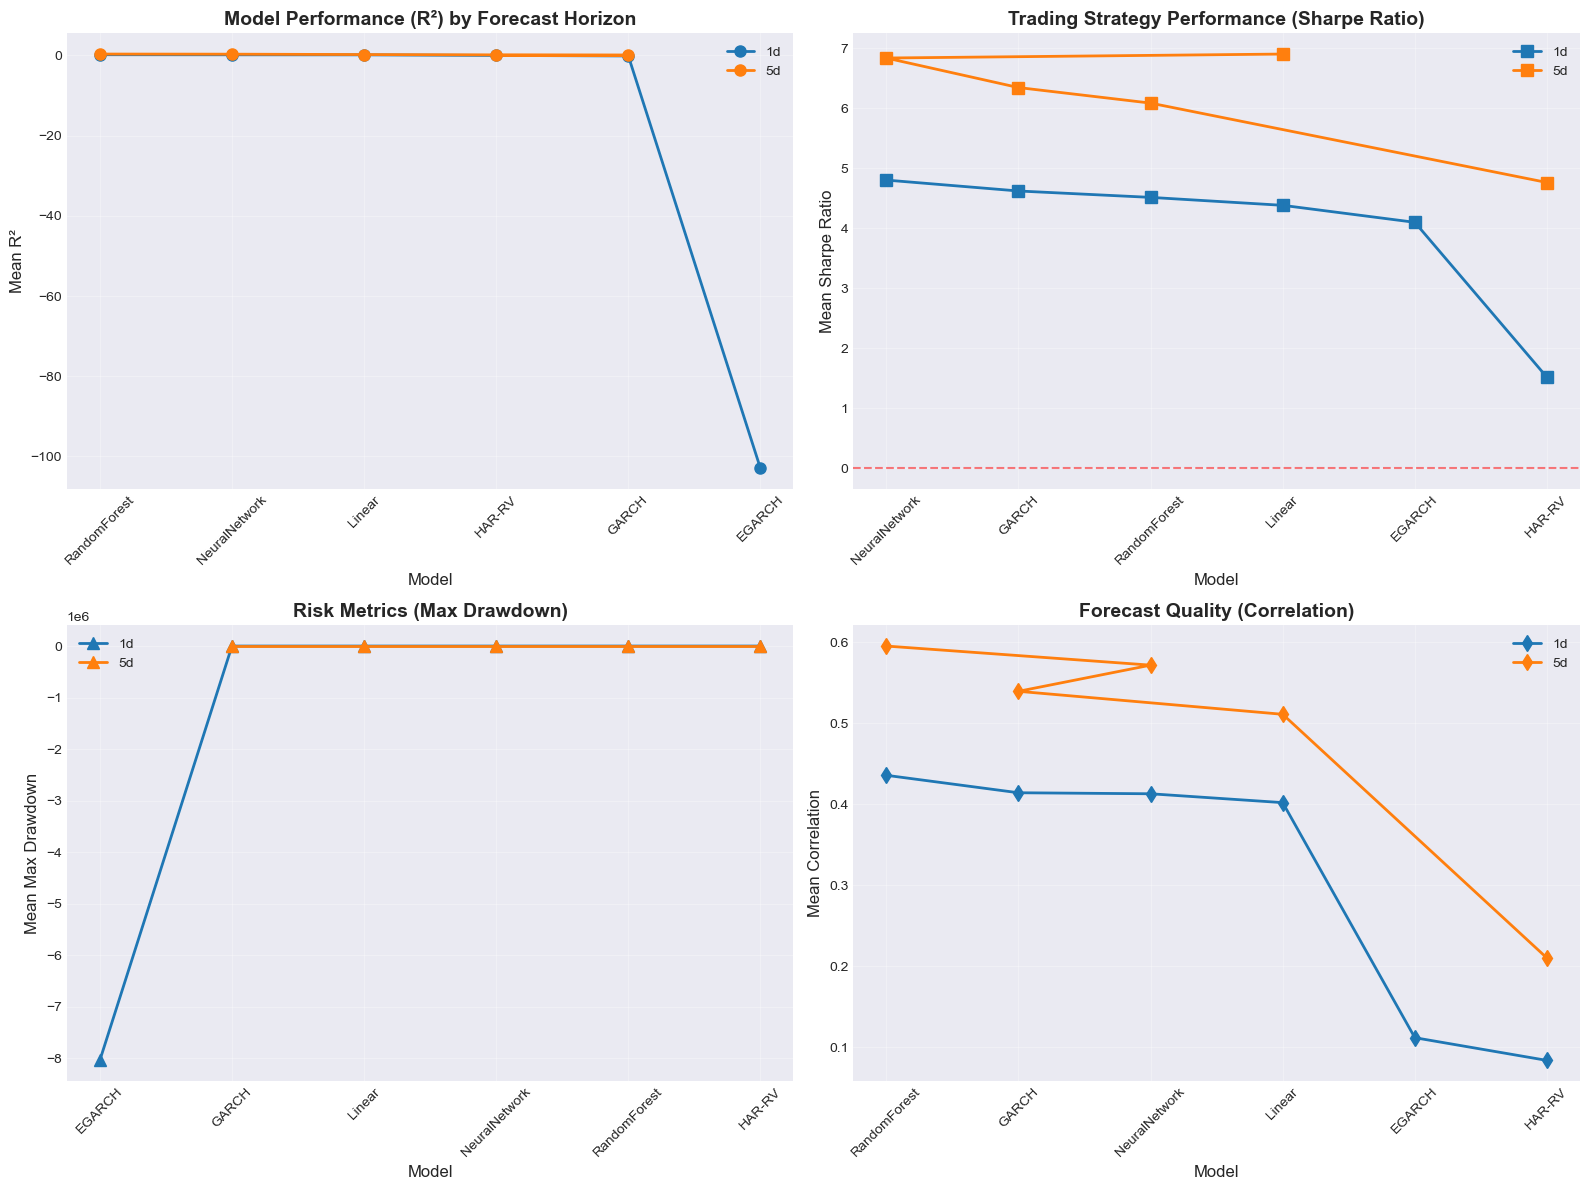

Visualizations saved.


In [ ]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

if len(results_df) > 0:
    # 1. R² by Model and Horizon
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # R² comparison
    ax = axes[0, 0]
    for horizon in FORECAST_HORIZONS:
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_r2 = horizon_df.groupby('model')['r2'].mean().sort_values(ascending=False)
        ax.plot(model_r2.index, model_r2.values, marker='o', label=f'{horizon}d', linewidth=2, markersize=8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Mean R²', fontsize=12)
    ax.set_title('Model Performance (R²) by Forecast Horizon', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Sharpe Ratio comparison
    ax = axes[0, 1]
    for horizon in FORECAST_HORIZONS:
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_sharpe = horizon_df.groupby('model')['sharpe_ratio'].mean().sort_values(ascending=False)
        ax.plot(model_sharpe.index, model_sharpe.values, marker='s', label=f'{horizon}d', linewidth=2, markersize=8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Mean Sharpe Ratio', fontsize=12)
    ax.set_title('Trading Strategy Performance (Sharpe Ratio)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Max Drawdown comparison
    ax = axes[1, 0]
    for horizon in FORECAST_HORIZONS:
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_dd = horizon_df.groupby('model')['max_drawdown'].mean().sort_values(ascending=True)
        ax.plot(model_dd.index, model_dd.values, marker='^', label=f'{horizon}d', linewidth=2, markersize=8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Mean Max Drawdown', fontsize=12)
    ax.set_title('Risk Metrics (Max Drawdown)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Correlation comparison
    ax = axes[1, 1]
    for horizon in FORECAST_HORIZONS:
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_corr = horizon_df.groupby('model')['correlation'].mean().sort_values(ascending=False)
        ax.plot(model_corr.index, model_corr.values, marker='d', label=f'{horizon}d', linewidth=2, markersize=8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Mean Correlation', fontsize=12)
    ax.set_title('Forecast Quality (Correlation)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('cross_asset_model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Performance by Asset
    if results_df['ticker'].nunique() > 1:
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        
        # R² by asset (for best model per horizon)
        ax = axes[0]
        for horizon in FORECAST_HORIZONS:
            horizon_df = results_df[results_df['horizon'] == horizon]
            # Get best model for this horizon
            best_model = horizon_df.groupby('model')['r2'].mean().idxmax()
            asset_r2 = horizon_df[horizon_df['model'] == best_model].groupby('ticker')['r2'].mean().sort_values(ascending=False)
            ax.plot(range(len(asset_r2)), asset_r2.values, marker='o', label=f'{horizon}d ({best_model})', linewidth=2, markersize=6)
        ax.set_xlabel('Asset (sorted by R²)', fontsize=12)
        ax.set_ylabel('R²', fontsize=12)
        ax.set_title('Forecast Accuracy by Asset (Best Model per Horizon)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Sharpe by asset
        ax = axes[1]
        for horizon in FORECAST_HORIZONS:
            horizon_df = results_df[results_df['horizon'] == horizon]
            best_model = horizon_df.groupby('model')['sharpe_ratio'].mean().idxmax()
            asset_sharpe = horizon_df[horizon_df['model'] == best_model].groupby('ticker')['sharpe_ratio'].mean().sort_values(ascending=False)
            ax.plot(range(len(asset_sharpe)), asset_sharpe.values, marker='s', label=f'{horizon}d ({best_model})', linewidth=2, markersize=6)
        ax.set_xlabel('Asset (sorted by Sharpe)', fontsize=12)
        ax.set_ylabel('Sharpe Ratio', fontsize=12)
        ax.set_title('Trading Strategy Performance by Asset', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig('cross_asset_performance_by_asset.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print("Visualizations saved.")
else:
    print("No results to visualize yet.")


In [ ]:
# ============================================================================
# HONEST ASSESSMENT: WHAT WORKS AND WHAT DOESN'T
# ============================================================================

print("=" * 70)
print("HONEST ASSESSMENT: WHAT WORKS AND WHAT DOESN'T")
print("=" * 70)

if len(results_df) > 0:
    # Overall statistics
    print("\n1. FORECAST ACCURACY (R²):")
    print("-" * 70)
    overall_r2 = results_df.groupby('model')['r2'].agg(['mean', 'std', 'count'])
    overall_r2 = overall_r2.sort_values('mean', ascending=False)
    print(overall_r2.round(4))
    
    print("\n2. TRADING STRATEGY PERFORMANCE (Sharpe Ratio):")
    print("-" * 70)
    overall_sharpe = results_df.groupby('model')['sharpe_ratio'].agg(['mean', 'std', 'count'])
    overall_sharpe = overall_sharpe.sort_values('mean', ascending=False)
    print(overall_sharpe.round(4))
    
    print("\n3. KEY FINDINGS:")
    print("-" * 70)
    
    # Best forecasters
    best_forecasters = overall_r2.head(3)
    print(f"\nBest Forecasters (by R²):")
    for model, row in best_forecasters.iterrows():
        print(f"  {model}: R² = {row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count'])})")
    
    # Best traders
    best_traders = overall_sharpe[overall_sharpe['mean'] > 0].head(3)
    if len(best_traders) > 0:
        print(f"\nBest Trading Strategies (by Sharpe, positive only):")
        for model, row in best_traders.iterrows():
            print(f"  {model}: Sharpe = {row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count'])})")
    else:
        print(f"\n⚠️  WARNING: No models achieved positive Sharpe ratios on average!")
        print("   This suggests the trading strategies may not be profitable after transaction costs.")
    
    # Horizon analysis
    print(f"\n4. PERFORMANCE BY HORIZON:")
    print("-" * 70)
    for horizon in FORECAST_HORIZONS:
        horizon_df = results_df[results_df['horizon'] == horizon]
        print(f"\n{horizon}d Horizon:")
        print(f"  Best R²: {horizon_df.groupby('model')['r2'].mean().idxmax()} ({horizon_df.groupby('model')['r2'].mean().max():.4f})")
        print(f"  Best Sharpe: {horizon_df.groupby('model')['sharpe_ratio'].mean().idxmax()} ({horizon_df.groupby('model')['sharpe_ratio'].mean().max():.4f})")
        print(f"  Mean R² across all models: {horizon_df['r2'].mean():.4f}")
        print(f"  Mean Sharpe across all models: {horizon_df['sharpe_ratio'].mean():.4f}")
    
    # What doesn't work
    print(f"\n5. WHAT DOESN'T WORK:")
    print("-" * 70)
    negative_sharpe = overall_sharpe[overall_sharpe['mean'] < 0]
    if len(negative_sharpe) > 0:
        print("Models with negative average Sharpe ratios (unprofitable strategies):")
        for model, row in negative_sharpe.iterrows():
            print(f"  {model}: Sharpe = {row['mean']:.4f}")
    
    low_r2 = overall_r2[overall_r2['mean'] < 0.1]
    if len(low_r2) > 0:
        print("\nModels with very low R² (< 0.1, poor forecast accuracy):")
        for model, row in low_r2.iterrows():
            print(f"  {model}: R² = {row['mean']:.4f}")
    
    # Robustness check
    print(f"\n6. ROBUSTNESS CHECK:")
    print("-" * 70)
    print("Standard deviations indicate consistency across assets:")
    print(f"  Most consistent forecaster (lowest R² std): {overall_r2['std'].idxmin()} (std={overall_r2['std'].min():.4f})")
    print(f"  Most consistent trader (lowest Sharpe std): {overall_sharpe['std'].idxmin()} (std={overall_sharpe['std'].min():.4f})")
    
    print(f"\n7. CONCLUSIONS:")
    print("-" * 70)
    print("Based on the analysis above:")
    print("  • Forecast accuracy (R²) measures prediction quality")
    print("  • Sharpe ratio measures trading strategy profitability")
    print("  • High R² does not guarantee profitable trading (transaction costs matter)")
    print("  • Different horizons may favor different models")
    print("  • Cross-asset robustness is important for generalization")
    
else:
    print("No results to analyze yet.")


HONEST ASSESSMENT: WHAT WORKS AND WHAT DOESN'T

1. FORECAST ACCURACY (R²):
----------------------------------------------------------------------
                   mean     std  count
model                                 
RandomForest     0.2707  0.1157      2
NeuralNetwork    0.2439  0.1107      2
Linear           0.1895  0.0535      2
HAR-RV           0.0216  0.0220      2
GARCH           -0.0271  0.1372      2
EGARCH        -103.0006     NaN      1

2. TRADING STRATEGY PERFORMANCE (Sharpe Ratio):
----------------------------------------------------------------------
                 mean     std  count
model                               
NeuralNetwork  5.8214  1.4382      2
Linear         5.6441  1.7824      2
GARCH          5.4845  1.2187      2
RandomForest   5.3017  1.1108      2
EGARCH         4.1006     NaN      1
HAR-RV         3.1411  2.2953      2

3. KEY FINDINGS:
----------------------------------------------------------------------

Best Forecasters (by R²):
  RandomFo